In [71]:
import toolviper
import xradio
import pathlib
import numba

import numpy as np
import pandas as pd
import calviper as cv

from xradio import measurement_set as ms

In [2]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
if not pathlib.Path.cwd().joinpath("data/gaincaltest2.ps.zarr").exists():
    toolviper.utils.data.download("gaincal.test.zarr", "data")

In [4]:
ps = ms.open_processing_set("data/gaincaltest2.ps.zarr")

In [5]:
ps.summary()

,name,intents,shape,polarization,scan_number,spw_name,field_name,source_name,line_name,field_coords,start_frequency,end_frequency
2,gaincaltest2_0,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_1#SW-01#FULL_RES_0,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",8.607155e+10,8.629030e+10
0,gaincaltest2_1,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(870, 45, 8, 4)","[XX, XY, YX, YY]","[3, 5, 8, 10, 12, 15, 17, 20, 22, 24]",X0000000000#ALMA_RB_03#BB_1#SW-01#FULL_RES_0,[J2255-3500_1],[J2255-3500_1],[],"[icrs, 22h55m53.83s, -35d00m00.00s]",8.607155e+10,8.629030e+10
1,gaincaltest2_2,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_2#SW-01#FULL_RES_1,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",8.794655e+10,8.816530e+10
6,gaincaltest2_3,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(870, 45, 8, 4)","[XX, XY, YX, YY]","[3, 5, 8, 10, 12, 15, 17, 20, 22, 24]",X0000000000#ALMA_RB_03#BB_2#SW-01#FULL_RES_1,[J2255-3500_1],[J2255-3500_1],[],"[icrs, 22h55m53.83s, -35d00m00.00s]",8.794655e+10,8.816530e+10
7,gaincaltest2_4,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_3#SW-01#FULL_RES_2,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",9.632156e+10,9.654030e+10
5,gaincaltest2_5,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(870, 45, 8, 4)","[XX, XY, YX, YY]","[3, 5, 8, 10, 12, 15, 17, 20, 22, 24]",X0000000000#ALMA_RB_03#BB_3#SW-01#FULL_RES_2,[J2255-3500_1],[J2255-3500_1],[],"[icrs, 22h55m53.83s, -35d00m00.00s]",9.632156e+10,9.654030e+10
4,gaincaltest2_6,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_4#SW-01#FULL_RES_3,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",9.819656e+10,9.841530e+10
3,gaincaltest2_7,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(870, 45, 8, 4)","[XX, XY, YX, YY]","[3, 5, 8, 10, 12, 15, 17, 20, 22, 24]",X0000000000#ALMA_RB_03#BB_4#SW-01#FULL_RES_3,[J2255-3500_1],[J2255-3500_1],[],"[icrs, 22h55m53.83s, -35d00m00.00s]",9.819656e+10,9.841530e+10


In [6]:
ps["gaincaltest2_0"]

<xarray.MeasurementSetXds> Size: 20MB
Dimensions:                     (baseline_id: 45, time: 957, frequency: 8,
                                 polarization: 4, uvw_label: 3)
Coordinates:
    baseline_antenna1_name      (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
    baseline_antenna2_name      (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
    scan_number                 (time) int64 8kB dask.array<chunksize=(957,), meta=np.ndarray>
  * time                        (time) float64 8kB 1.503e+09 ... 1.503e+09
  * frequency                   (frequency) float64 64B 8.607e+10 ... 8.629e+10
  * polarization                (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 345kB dask.array<chunksize=(957, 45), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool 1MB dask.array<chunksize=(957, 45, 8, 4), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 345kB dask.array<chunksize=(957, 45), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 1MB dask.array<chunksize=(957, 45, 3), meta=np.ndarray>
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 11MB dask.array<chunksize=(957, 45, 8, 4), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 6MB dask.array<chunksize=(957, 45, 8, 4), meta=np.ndarray>
Attributes:
    creation_date:     2024-12-17T00:23:00.044895+00:00
    data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'flag': 'FL...
    observation_info:  {'observer': ['lknee'], 'project': 'uid://A002/X1f841f...
    partition_info:    {'field_name': ['J2255-3500_0'], 'intents': ['CALIBRAT...
    processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
    schema_version:    4.0.-9994
    type:              visibility
    xradio_version:    0.0.45
    antenna_xds:       <xarray.Dataset> Size: 2kB\nDimensions:               ...

In [7]:
df_gains = pd.read_csv("gains.csv")
gains = df_gains.gain.apply(complex).to_numpy()
gains

array([-0.63455564+0.47076233j,  1.15841049-0.81354628j,
        1.32849216+0.20964037j,  0.7710231 +0.13511301j,
        0.42394351-0.64036523j,  0.17546983-1.09119839j,
        0.41194325-0.57720941j, -0.00666993+0.52208018j,
        0.25330102-0.93767723j,  1.12460157+0.44485419j])

In [8]:
df_vis = pd.read_csv("vis.csv")
df_vis.drop(columns=["Unnamed: 0"], inplace=True)

vis = df_vis.vis.apply(complex).to_numpy()

ant_a = df_vis.ant_a.to_numpy()
ant_b = df_vis.ant_b.to_numpy()

In [74]:
from calviper.math.loss import mean_squared_error as mse

def build_vis(vis, index_a, index_b):
    count = 1
    
    X = np.zeros((10, 10), dtype=complex)

    for i in range(45):
        m = index_a[i]
        n = index_b[i]

        X[m, n] = X[m, n]*(count - 1) + vis[i]
        X[m, n] = X[m, n]/count

        X[n, m] = X[m, n].conj()

    return X

In [75]:
X = build_vis(vis, ant_a, ant_b)

In [113]:
solver = cv.math.solver.least_squares.LeastSquaresSolver()

In [12]:
g = solver.solve(
    vis=X,
    iterations=10,
    optimizer=cv.math.optimizer.MeanSquaredError(alpha=0.2),
    stopping=1e-2
)

[2024-12-17 16:35:09,933]     INFO    viperlog:  Iteration: (5)	Stopping criterion reached: 0.009207611105772 


In [19]:
sub_ps = ps.sel(intents="CALIBRATE_DELAY#ON_SOURCE", scan_number=2)
sub_ps.summary()

,name,intents,shape,polarization,scan_number,spw_name,field_name,source_name,line_name,field_coords,start_frequency,end_frequency
1,gaincaltest2_0,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_1#SW-01#FULL_RES_0,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",8.607155e+10,8.629030e+10
0,gaincaltest2_2,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_2#SW-01#FULL_RES_1,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",8.794655e+10,8.816530e+10
3,gaincaltest2_4,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_3#SW-01#FULL_RES_2,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",9.632156e+10,9.654030e+10
2,gaincaltest2_6,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_4#SW-01#FULL_RES_3,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",9.819656e+10,9.841530e+10


In [21]:
sps = sub_ps["gaincaltest2_0"]

In [32]:
V = sps.VISIBILITY.mean(dim="time").data.compute()

In [51]:
base = sps.baseline_id.to_numpy()

In [53]:
base

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [108]:
def build_matrix(vis, index_a, index_b):
    length = index_a.shape[0]
    
    X = np.zeros((length, length), dtype=complex)
    
    for m in index_a:
        for n in index_b[1:]:
            X[m, n] = vis[m]
            X [n, m] = vis[m].conj()

    return X
            
            

In [112]:
v = build_matrix(V, base, base)

(45, 45)

In [122]:
g = solver.solve(
    vis=v,
    iterations=20,
    optimizer=cv.math.optimizer.MeanSquaredError(alpha=0.2),
    stopping=1e-2
)

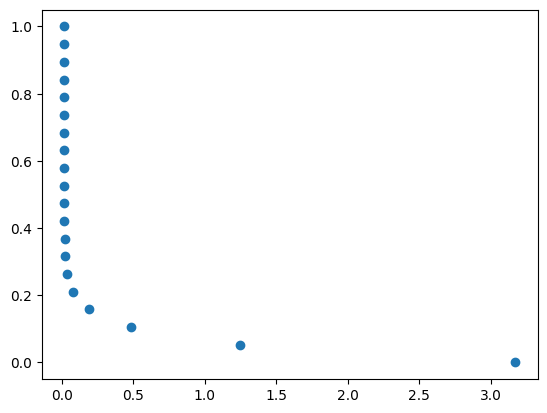

In [123]:
import matplotlib.pyplot as plt

plt.scatter(solver.losses, np.linspace(0, 1, len(solver.losses)))